In [1]:

import numpy as np
import pylab

import torch
import torch.optim as optim

from tqdm.notebook import tqdm

from mymodule import fit
from mymodule import evaluate_history

# I used the deepclean module here
# https://github.com/ML4GW/DeepClean/tree/main/libs
from deepclean.signal import filter
from deepclean.architectures import convolutional_autoencoder
from deepclean.trainer import criterion
from deepclean.trainer import dataloader


In [2]:
torch.manual_seed(0)

In [3]:
# Data Preprocessing

sample_rate = 4096

# Parameters of bandpass_filter
freq_low = 50
freq_high = 70
order = 8
bandpass_filter = filter.BandpassFilter(freq_low, freq_high, sample_rate, order)

#"witness_train" is numpy_data created by sin(2π*60*t)
witness_train = np.load("/home/k-takatani/npy_data/p60_train.npy")
witness_train = (witness_train - witness_train.mean())/witness_train.std()
witness_train = witness_train.reshape((1, len(witness_train)))

#"strain_train" is numpy_data created by (1 + sin(2π*1*t))sin(2π*60*t) + gaussian_noise
strain_train = np.load("/home/k-takatani/npy_data/Lp60_train.npy")
strain_train = bandpass_filter(strain_train)
strain_train = (strain_train - strain_train.mean())/strain_train.std()

dataset_train = dataloader.ChunkedTimeSeriesDataset(witness_train,
                                              strain_train,
                                              kernel_length=8,
                                              kernel_stride=0.25,
                                              sample_rate=4096,
                                              batch_size=10,
                                              shuffle=False,
                                              chunk_length=-1,
                                              device="cuda:0")

#The test data is just the noise seed value changed from the train data.
witness_test = np.load("/home/k-takatani/npy_data/p60_test.npy")
witness_test = (witness_test - witness_test.mean())/witness_test.std()
witness_test = witness_test.reshape((1, len(witness_test)))


strain_test = np.load("/home/k-takatani/npy_data/Lp60_test.npy")
strain_test = bandpass_filter(strain_test)
strain_test = (strain_test - strain_test.mean())/strain_test.std()

dataset_test = dataloader.ChunkedTimeSeriesDataset(witness_test,
                                              strain_test,
                                              kernel_length=8,
                                              kernel_stride=4,
                                              sample_rate=4096,
                                              batch_size=5,
                                              chunk_length=-1,
                                              shuffle=False,
                                              device="cuda:0")

print("witness_train.shape:", dataset_train.X.shape)
print("witness_test.shape:", dataset_test.X.shape)


witness_train.shape: torch.Size([3418, 1, 32768])
witness_test.shape: torch.Size([214, 1, 32768])


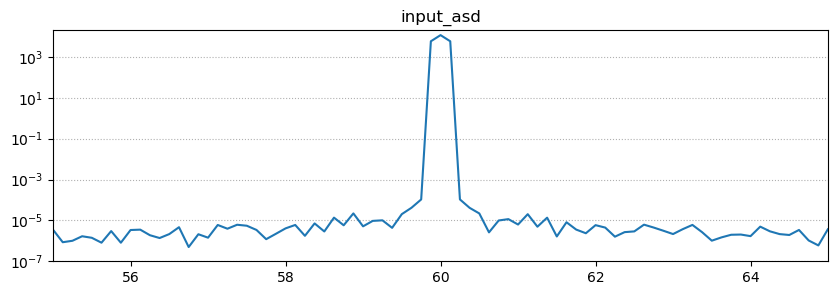

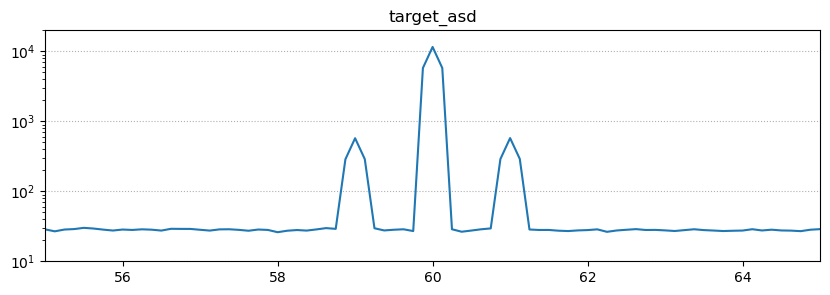

In [12]:
# ASD of each data

fft_length = 8
sample_rate = 4096
overlap_times = 4
xlim = [55, 65]

nperseg = int(fft_length * sample_rate)
nstride = nperseg - overlap_times * sample_rate
window = torch.hann_window(nperseg).to("cpu")

witness1 = torch.tensor(witness_train).squeeze(0)

strain = torch.tensor(strain_train)

witness1_asd = torch.stft(witness1, n_fft=nperseg, hop_length=nstride,window=window, normalized=False, center=False, return_complex=True).abs()
witness1_asd = torch.mean(witness1_asd, 1)
strain_asd = torch.stft(strain, n_fft=nperseg, hop_length=nstride,window=window, normalized=False, center=False, return_complex=True).abs()
strain_asd = torch.mean(strain_asd, 1)

freq = np.arange(0, 2048+(1/fft_length), (1/fft_length))

pylab.figure(figsize=(10, 3))
pylab.plot(freq, witness1_asd)
pylab.xlim(xlim[0], xlim[1])
pylab.ylim(1e-7, 2*1e4)
pylab.yscale("log")
pylab.title("input_asd")
pylab.grid(which='major',axis='y' ,linestyle='dotted')

pylab.figure(figsize=(10, 3))
pylab.plot(freq, strain_asd)
pylab.xlim(xlim[0], xlim[1])
pylab.ylim(1e1, 2*1e4)
pylab.yscale("log")
pylab.title("target_asd")
pylab.grid(which='major',axis='y' ,linestyle='dotted')

In [11]:
num_witness = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
    
lr = 0.00001

net = convolutional_autoencoder.DeepCleanAE(1).to(device)
loss = criterion.CompositePSDLoss(alpha=1, 
                                  sample_rate=4096, 
                                  fftlength=4, 
                                  freq_low=55,
                                  freq_high=65,
                                  device="cuda:0")

optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
history = np.zeros((0,3))

cuda:0


In [6]:
num_epochs = 30
history = fit(net, optimizer, loss, 0.5,  num_epochs, dataset_train, dataset_test, device, history, scheduler)

Learning_Rate = [1e-05]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [1/30], loss: 0.09664  val_loss: 0.19303
Learning_Rate = [1e-05]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [2/30], loss: 0.09600  val_loss: 0.19258
Learning_Rate = [1e-05]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [3/30], loss: 0.09582  val_loss: 0.19222
Learning_Rate = [1e-05]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [4/30], loss: 0.09565  val_loss: 0.19189
Learning_Rate = [1e-05]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [5/30], loss: 0.09549  val_loss: 0.19158
Learning_Rate = [1.0000000000000002e-06]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [6/30], loss: 0.09539  val_loss: 0.19155
Learning_Rate = [1.0000000000000002e-06]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [7/30], loss: 0.09538  val_loss: 0.19151
Learning_Rate = [1.0000000000000002e-06]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [8/30], loss: 0.09536  val_loss: 0.19148
Learning_Rate = [1.0000000000000002e-06]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [9/30], loss: 0.09535  val_loss: 0.19145
Learning_Rate = [1.0000000000000002e-06]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [10/30], loss: 0.09533  val_loss: 0.19142
Learning_Rate = [1.0000000000000002e-07]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [11/30], loss: 0.09532  val_loss: 0.19142
Learning_Rate = [1.0000000000000002e-07]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [12/30], loss: 0.09532  val_loss: 0.19141
Learning_Rate = [1.0000000000000002e-07]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [13/30], loss: 0.09532  val_loss: 0.19141
Learning_Rate = [1.0000000000000002e-07]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [14/30], loss: 0.09531  val_loss: 0.19141
Learning_Rate = [1.0000000000000002e-07]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [15/30], loss: 0.09531  val_loss: 0.19141
Learning_Rate = [1.0000000000000004e-08]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [16/30], loss: 0.09531  val_loss: 0.19141
Learning_Rate = [1.0000000000000004e-08]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [17/30], loss: 0.09531  val_loss: 0.19141
Learning_Rate = [1.0000000000000004e-08]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [18/30], loss: 0.09531  val_loss: 0.19141
Learning_Rate = [1.0000000000000004e-08]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [19/30], loss: 0.09531  val_loss: 0.19141
Learning_Rate = [1.0000000000000004e-08]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [20/30], loss: 0.09531  val_loss: 0.19140
Learning_Rate = [1.0000000000000005e-09]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [21/30], loss: 0.09531  val_loss: 0.19140
Learning_Rate = [1.0000000000000005e-09]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [22/30], loss: 0.09531  val_loss: 0.19140
Learning_Rate = [1.0000000000000005e-09]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [23/30], loss: 0.09531  val_loss: 0.19140
Learning_Rate = [1.0000000000000005e-09]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [24/30], loss: 0.09531  val_loss: 0.19140
Learning_Rate = [1.0000000000000005e-09]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [25/30], loss: 0.09531  val_loss: 0.19140
Learning_Rate = [1.0000000000000006e-10]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [26/30], loss: 0.09531  val_loss: 0.19140
Learning_Rate = [1.0000000000000006e-10]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [27/30], loss: 0.09531  val_loss: 0.19140
Learning_Rate = [1.0000000000000006e-10]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [28/30], loss: 0.09531  val_loss: 0.19140
Learning_Rate = [1.0000000000000006e-10]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [29/30], loss: 0.09531  val_loss: 0.19140
Learning_Rate = [1.0000000000000006e-10]


  0%|          | 0/342 [00:00<?, ?it/s]

Epoch [30/30], loss: 0.09531  val_loss: 0.19140


初期状態: 損失: 0.09664 精度: 0.19303
最終状態: 損失: 0.09531 精度: 0.19140


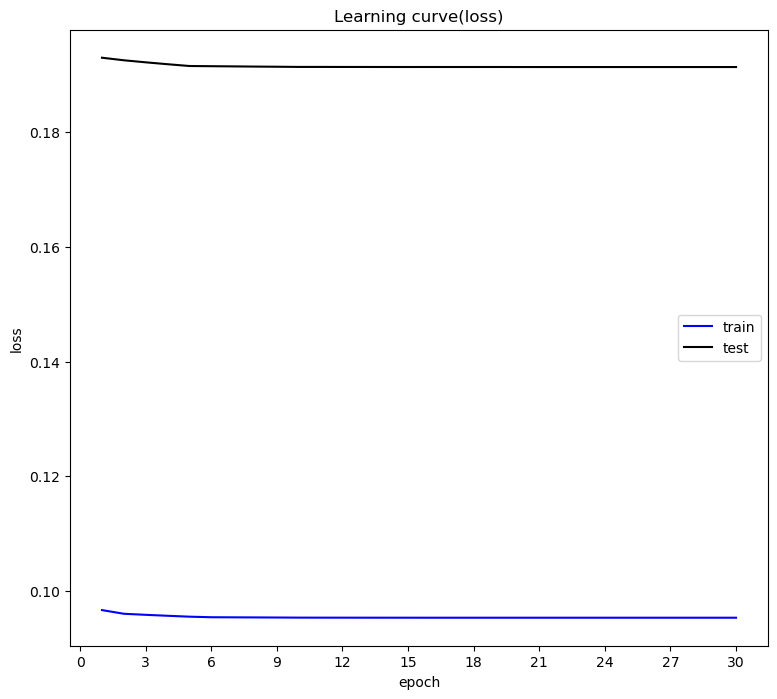

In [7]:
evaluate_history(history)

In [8]:
# Calculate asd of data after noise removal from dataset

witness1 = []
witness2 = []
strain = []
output_array = []

kernel_stride = 4
sample_rate = 4096
fft_length = 8
overlap_times = 4

overlap_samples = kernel_stride *sample_rate

nperseg = int(fft_length * sample_rate)
nstride = nperseg - overlap_times * sample_rate
window = torch.hann_window(nperseg).to("cpu")

initial_input = True
initial_target = True
initial_output = True

net.eval()


for inputs1, targets in tqdm(dataset_test):
    input_batches = inputs1.squeeze(1)
    # "inputs_bathces" are used to restore "witness" and "inputs" are used to "outputs".
    inputs = inputs1.to(device)
    outputs = net(inputs).to("cpu").detach()
    
    #Remove overlapping parts in the dataset and return to one-dimensional data.
    for input in input_batches:
        if initial_input:
            witness1 = np.append(witness1, input.to("cpu"))
            initial_input = False
        else:
            witness1 = np.append(witness1, input[overlap_samples:].to("cpu"))

    for target in targets:
        if initial_target:
            strain = np.append(strain, target.to("cpu"))
            initial_target = False
        else:
            strain = np.append(strain, target[overlap_samples:].to("cpu"))

    for output in outputs:
        if initial_output:
            output_array = np.append(output_array, output.to("cpu"))
            initial_output = False         
        else:
            output_array = np.append(output_array, output[overlap_samples:].to("cpu"))
            
subtracted = strain - output_array

witness1 = torch.tensor(witness1)
strain = torch.tensor(strain)
subtracted = torch.tensor(subtracted)

witness1_asd = torch.stft(witness1, n_fft=nperseg, hop_length=nstride,window=window, normalized=False, center=False, return_complex=True).abs()
witness1_asd = torch.mean(witness1_asd, 1)
strain_asd = torch.stft(strain, n_fft=nperseg, hop_length=nstride,window=window, normalized=False, center=False, return_complex=True).abs()
strain_asd = torch.mean(strain_asd, 1)
subtracted_asd = torch.stft(subtracted, n_fft=nperseg, hop_length=nstride,window=window, normalized=False, center=False, return_complex=True).abs()
subtracted_asd = torch.mean(subtracted_asd, 1)

freq = np.arange(0, 2048+(1/fft_length), (1/fft_length))

  0%|          | 0/43 [00:00<?, ?it/s]

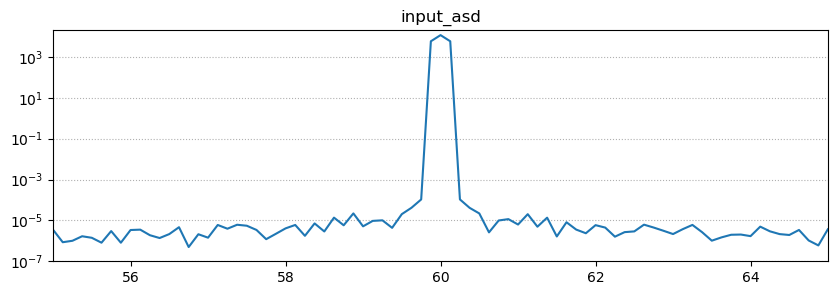

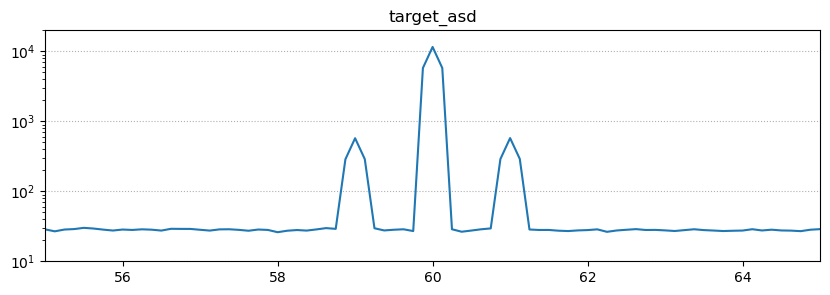

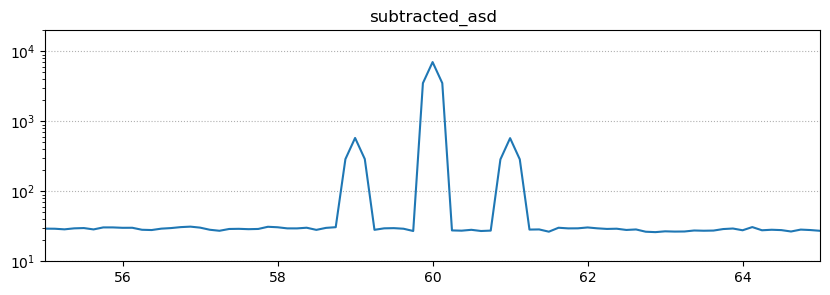

In [13]:
xlim = [55, 65]
ylim = [1e2, 1.2*1e4]

pylab.figure(figsize=(10, 3))
pylab.plot(freq, witness1_asd)
pylab.xlim(xlim[0], xlim[1])
pylab.ylim(1e-7, 2*1e4)
pylab.yscale("log")
pylab.title("input_asd")
pylab.grid(which='major',axis='y' ,linestyle='dotted')

pylab.figure(figsize=(10, 3))
pylab.plot(freq, strain_asd)
pylab.xlim(xlim[0], xlim[1])
pylab.ylim(1e1, 2*1e4)
pylab.yscale("log")
pylab.title("target_asd")
pylab.grid(which='major',axis='y' ,linestyle='dotted')

pylab.figure(figsize=(10, 3))
pylab.plot(freq, subtracted_asd)
pylab.xlim(xlim[0], xlim[1])
pylab.ylim(1e1, 2*1e4)
pylab.yscale("log")
pylab.title("subtracted_asd")
pylab.grid(which='major',axis='y' ,linestyle='dotted')
